### Verification of Explanation Quality Metrics

This notebook verifies the calculation of explanation quality metrics for the CNN spam detection model.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.constants import DATA_PATH, GLOVE_PATH

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')

# Display sample data
test_df.head()

,subject,text,label,source,sender_hash,reply_to_hash,date
0,"RE: Our friends the Palestinians, Our servants...",> sent saturday october 05 2002 9 35 pm > <EMA...,0,easy_ham,b2a1ed072dac5390032107d68207da628871941f752c71...,dc81ba9d6d565d4dbdb576bdf65e2e1f1235be5883c36f...,"Sat, 05 Oct 2002 23:01:25 -0700"
1,"Re: Our friends the Palestinians, Our servants...",>> sent saturday october 05 2002 9 35 pm >> <E...,0,easy_ham,66f825a92e3e1ec67d51d37bf534b1558a51ffd089d1b4...,,"Sun, 06 Oct 2002 00:25:36 -0700"
2,xine src package,xine src package same mplayer src package with...,0,easy_ham,1f6887e4a68a4fc73d600020d9b745081796c5be5f7a76...,492368811b79453838d5e7e3692f607adee8d7e71ddd2e...,"Sun, 06 Oct 2002 12:10:34 +0300"
3,Re: xine src package,re xine src package once upon time roi wrote >...,0,easy_ham,da2d626a2a4bd882f33e58637155361d2b9fefecda09cc...,492368811b79453838d5e7e3692f607adee8d7e71ddd2e...,"Sun, 06 Oct 2002 12:36:28 +0200"
4,"Re: Our friends the Palestinians, Our servants...",re our friends palestinians our servants gover...,0,easy_ham,b85ead8fd1390927e52f44ee8cc0ecf949b876dc71d341...,,"Sun, 06 Oct 2002 10:20:37 -0300"


In [3]:
from utils.functions import set_seed, build_vocab, encode

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

# Prepare test data
X_test_tensor = torch.tensor([encode(t, word2idx, max_len) for t in test_df['text']])
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [4]:
from preprocess.data_loader import load_glove_embeddings
from models.cnn import SpamCNN

# Load embeddings
pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

# Load the trained CNN model
model_path = DATA_PATH + '/trained-models/spam_cnn_final.pt'
cnn_model = SpamCNN(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                    pretrained_embeddings=pretrained_embeddings)
cnn_model.load(model_path, map_location=device)
cnn_model.eval()

SpamCNN(
  (embedding): Embedding(25245, 300)
  (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [5]:
# Get model predictions
with torch.no_grad():
    y_pred_probs = cnn_model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()

# Display prediction statistics
pred_stats = {
    "Accuracy": (y_pred == y_test_tensor).float().mean().item(),
    "Positive predictions": y_pred.sum().item(),
    "Negative predictions": (1 - y_pred).sum().item(),
    "Total samples": len(y_test_tensor)
}

pd.DataFrame([pred_stats]).T

,0
Accuracy,0.576245
Positive predictions,178.000000
Negative predictions,428.000000
Total samples,606.000000


### A. Detailed Analysis of AUC-Del and AUC-Ins Metrics

Let's examine these metrics by visualizing the deletion and insertion curves for a few samples:

In [6]:
def detailed_auc_del_ins(model, x_single, cam_single, sample_idx, sample_text):
    """Analyze deletion and insertion curves for a single sample"""
    model.eval()
    
    # Ensure tensors are on the right device
    device = next(model.parameters()).device
    x_single = x_single.to(device).long()
    cam_single = cam_single.to(device)
    
    # Sort indices by importance
    _, indices = torch.sort(cam_single, descending=True)
    
    # For deletion curve
    deletions = []
    pad_token = 0  # PAD token
    
    # Base prediction with all tokens
    with torch.no_grad():
        base_pred = model(x_single.unsqueeze(0)).item()
    deletions.append(base_pred)
    
    # For insertion curve
    insertions = []
    x_masked = torch.ones_like(x_single).long() * pad_token
    
    # Base prediction with all tokens masked
    with torch.no_grad():
        masked_pred = model(x_masked.unsqueeze(0)).item()
    insertions.append(masked_pred)
    
    # Get non-pad indices to know actual text length
    non_pad_mask = (x_single != pad_token)
    non_pad_indices = torch.nonzero(non_pad_mask, as_tuple=False).squeeze()
    if non_pad_indices.dim() == 0:
        actual_len = 1
    else:
        actual_len = len(non_pad_indices)
    
    # Progressively delete/insert tokens at 10% intervals of actual text length
    steps = min(10, actual_len)
    step_size = max(1, actual_len // steps)
    
    # Collect results at each step
    for i in range(1, steps + 1):
        step_idx = min(i * step_size, actual_len)
        
        # --- Deletion ---
        x_del = x_single.clone()
        x_del[indices[:step_idx]] = pad_token
        
        with torch.no_grad():
            del_pred = model(x_del.unsqueeze(0)).item()
        deletions.append(del_pred)
        
        # --- Insertion ---
        x_ins = x_masked.clone()
        x_ins[indices[:step_idx]] = x_single[indices[:step_idx]]
        
        with torch.no_grad():
            ins_pred = model(x_ins.unsqueeze(0)).item()
        insertions.append(ins_pred)
    
    # Calculate AUC values
    auc_del = np.trapz(deletions) / len(deletions)
    auc_ins = np.trapz(insertions) / len(insertions)
    
    # Plot results
    plt.figure(figsize=(14, 6))
    
    # Plot deletion curve
    plt.subplot(1, 2, 1)
    plt.plot(range(len(deletions)), deletions, 'r-o', label=f'Deletion Curve (AUC: {auc_del:.4f})')
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Decision Boundary')
    plt.xlabel('% Most Important Tokens Deleted')
    plt.ylabel('Model Prediction Score')
    plt.title(f'Deletion Curve - Sample {sample_idx}')
    plt.xticks(range(len(deletions)), [f"{i*10}%" for i in range(len(deletions))])
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot insertion curve
    plt.subplot(1, 2, 2)
    plt.plot(range(len(insertions)), insertions, 'g-o', label=f'Insertion Curve (AUC: {auc_ins:.4f})')
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Decision Boundary')
    plt.xlabel('% Most Important Tokens Inserted')
    plt.ylabel('Model Prediction Score')
    plt.title(f'Insertion Curve - Sample {sample_idx}')
    plt.xticks(range(len(insertions)), [f"{i*10}%" for i in range(len(insertions))])
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f"Sample Text: {sample_text[:50]}...", fontsize=10)
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    return auc_del, auc_ins

Generating explanations...

--- Sample 150 ---
Label: Ham
Prediction: 0.0000 (Ham)

--- Sample 150 ---
Label: Ham
Prediction: 0.0000 (Ham)


/tmp/ipykernel_255/3860062601.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(deletions) / len(deletions)
/tmp/ipykernel_255/3860062601.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(insertions) / len(insertions)


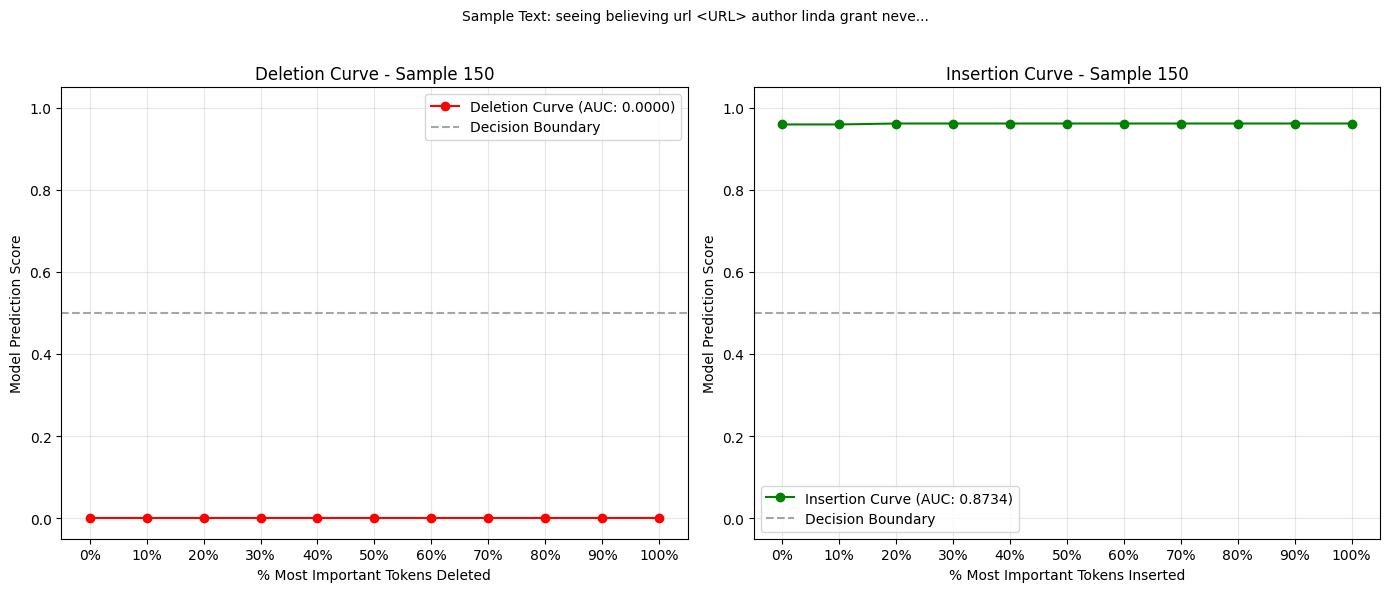


--- Sample 357 ---
Label: Ham
Prediction: 0.0137 (Ham)


/tmp/ipykernel_255/3860062601.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(deletions) / len(deletions)
/tmp/ipykernel_255/3860062601.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(insertions) / len(insertions)


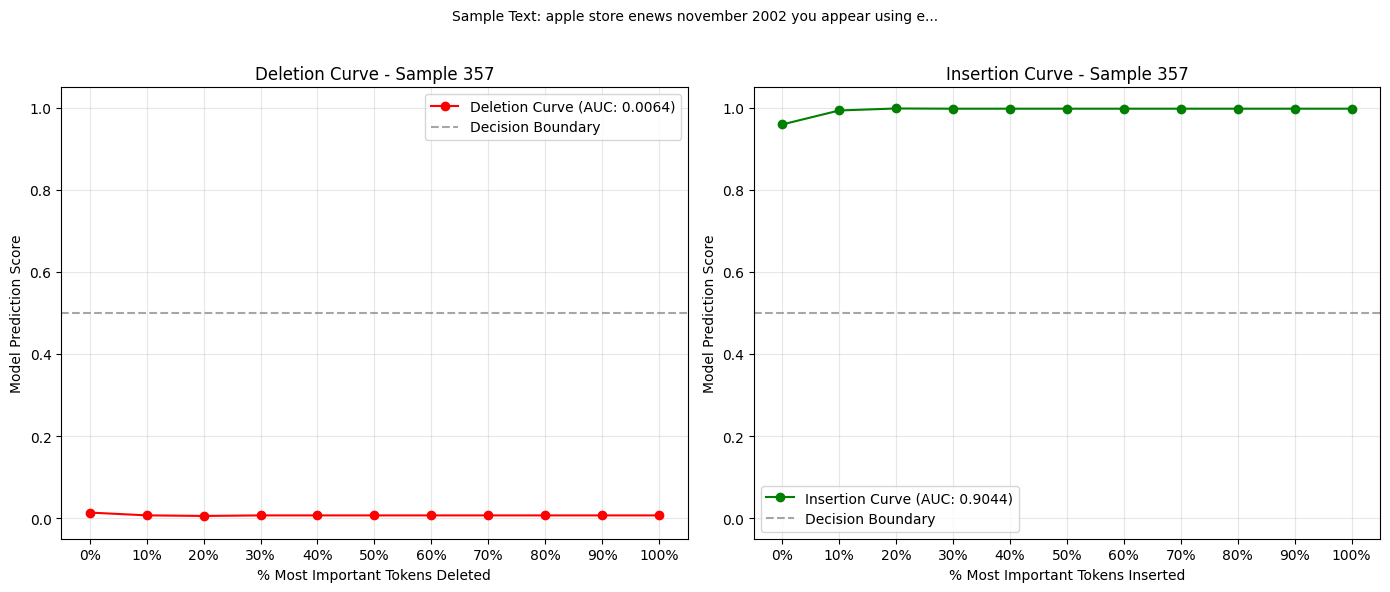


--- Sample 402 ---
Label: Ham
Prediction: 0.0000 (Ham)


/tmp/ipykernel_255/3860062601.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(deletions) / len(deletions)
/tmp/ipykernel_255/3860062601.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(insertions) / len(insertions)


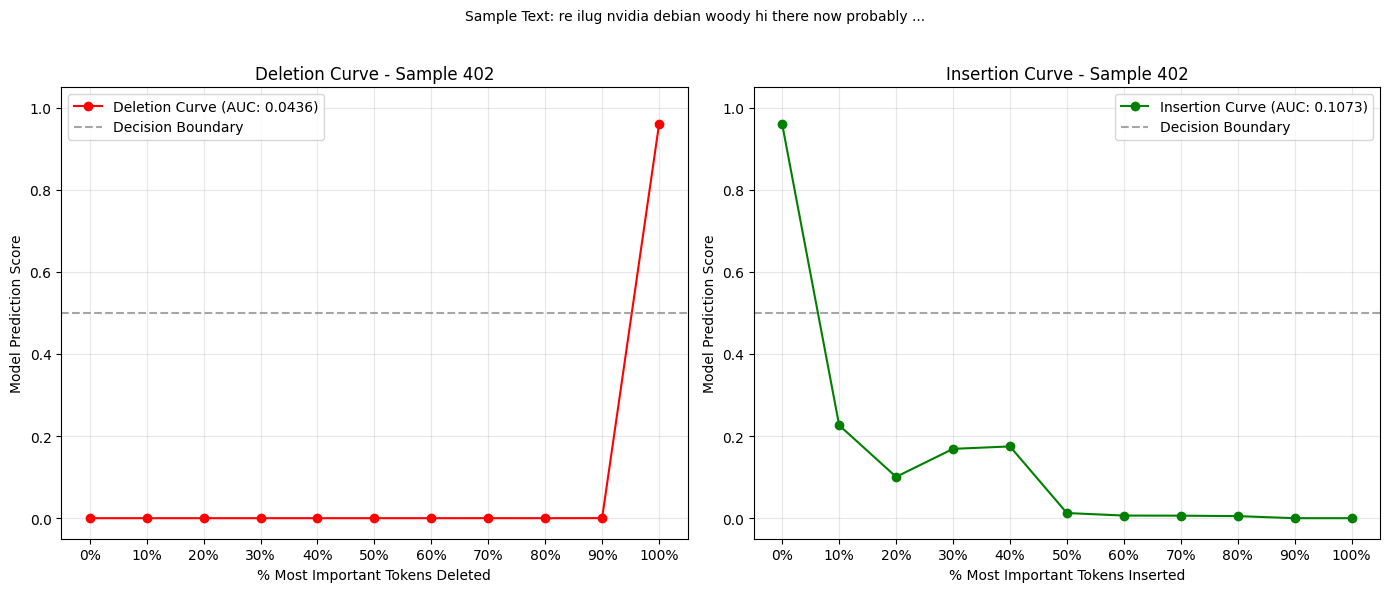


--- Sample 416 ---
Label: Spam
Prediction: 1.0000 (Spam)


/tmp/ipykernel_255/3860062601.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(deletions) / len(deletions)
/tmp/ipykernel_255/3860062601.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(insertions) / len(insertions)


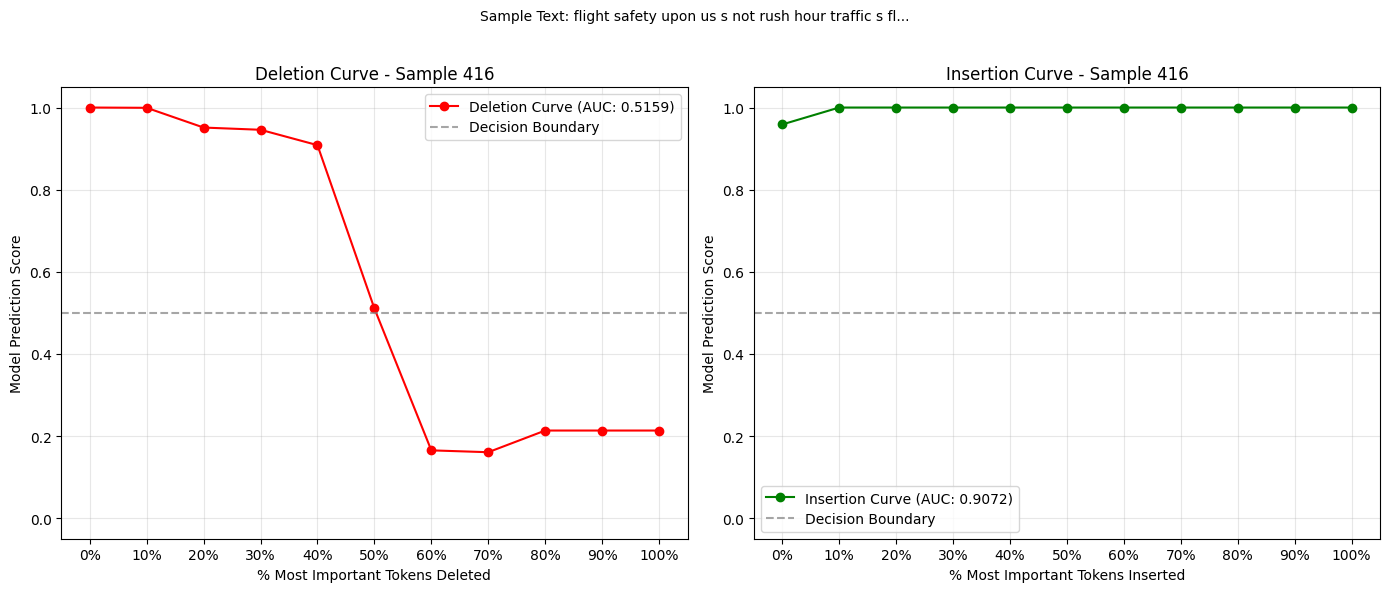

In [7]:
# Generate Grad-CAM explanations
print("Generating explanations...")
cam_maps = cnn_model.grad_cam(X_test_tensor)

# Analyze a few samples
samples = (150, 357, 402, 416)
for i in samples:
    sample_text = test_df['text'].iloc[i]
    print(f"\n--- Sample {i} ---")
    print(f"Label: {'Spam' if test_df['label'].iloc[i] == 1 else 'Ham'}")
    print(f"Prediction: {y_pred_probs[i].item():.4f} ({'Spam' if y_pred[i] == 1 else 'Ham'})")
    
    auc_del, auc_ins = detailed_auc_del_ins(
        cnn_model, 
        X_test_tensor[i], 
        cam_maps[i], 
        i,
        sample_text
    )

### B. Analysis of Jaccard Stability

The Jaccard stability score measures how consistent the model's explanations are under small perturbations.
Let's verify this metric by visualizing the top-k important tokens before and after perturbation:

In [8]:
def verify_jaccard_stability(model, x_single, cam_original, sample_idx, sample_text, k=5, num_perturbations=5):
    """Verify Jaccard stability calculation"""
    model.eval()
    
    # Ensure tensors are on the right device
    device = next(model.parameters()).device
    x_single = x_single.to(device).long()
    cam_original = cam_original.to(device)
    
    # Identify non-padding tokens
    non_pad_mask = (x_single != 0)  # 0 is PAD
    non_pad_indices = torch.nonzero(non_pad_mask, as_tuple=False).squeeze()
    
    if non_pad_indices.numel() == 0:
        print(f"Sample {sample_idx} has no non-padding tokens")
        return
    
    # Reshape indices if needed
    if non_pad_indices.dim() == 0:
        non_pad_indices = non_pad_indices.unsqueeze(0)
    
    # Get top-k original indices
    k_orig = min(k, cam_original.numel())
    _, top_k_orig_indices = torch.topk(cam_original, k_orig)
    top_k_orig_set = set(top_k_orig_indices.cpu().tolist())
    
    # Get corresponding tokens
    top_k_tokens = [idx2word.get(x_single[idx].item(), "<UNK>") for idx in top_k_orig_indices]
    print(f"Top {k} tokens in original: {', '.join(top_k_tokens)}")
    
    # Run multiple perturbations
    jaccard_scores = []
    
    plt.figure(figsize=(15, 5 * num_perturbations))
    plt.subplots_adjust(hspace=0.5)
    
    for p in range(num_perturbations):
        # Clone input
        x_perturbed = x_single.clone()
        
        # Randomly perturb 10% of non-pad tokens to UNK (token ID 1)
        if non_pad_indices.numel() > 0:
            num_to_perturb = max(1, int(non_pad_indices.size(0) * 0.1))
            perm = torch.randperm(non_pad_indices.size(0), device=device)
            indices_to_perturb = non_pad_indices[perm[:num_to_perturb]]
            x_perturbed[indices_to_perturb] = 1  # UNK token
        
        # Get perturbed CAM
        with torch.no_grad():
            cam_perturbed = model.grad_cam(x_perturbed.unsqueeze(0))[0]
        
        # Get top-k perturbed indices
        k_pert = min(k, cam_perturbed.numel())
        _, top_k_pert_indices = torch.topk(cam_perturbed, k_pert)
        top_k_pert_set = set(top_k_pert_indices.cpu().tolist())
        
        # Get corresponding tokens
        pert_tokens = [idx2word.get(x_perturbed[idx].item(), "<UNK>") for idx in top_k_pert_indices]
        
        # Calculate Jaccard similarity
        intersection = len(top_k_orig_set & top_k_pert_set)
        union = len(top_k_orig_set | top_k_pert_set)
        jaccard = intersection / union if union > 0 else 0.0
        jaccard_scores.append(jaccard)
        
        # Visualize the CAMs
        plt.subplot(num_perturbations, 2, p*2 + 1)
        plt.bar(range(k_orig), [cam_original[idx].item() for idx in top_k_orig_indices])
        plt.title(f"Original CAM - Top {k} Tokens")
        plt.xticks(range(k_orig), top_k_tokens, rotation=45)
        plt.ylim(0, 1)
        
        plt.subplot(num_perturbations, 2, p*2 + 2)
        plt.bar(range(k_pert), [cam_perturbed[idx].item() for idx in top_k_pert_indices])
        plt.title(f"Perturbed CAM #{p+1} - Top {k} Tokens (Jaccard: {jaccard:.4f})")
        plt.xticks(range(k_pert), pert_tokens, rotation=45)
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.suptitle(f"Sample {sample_idx} - Jaccard Stability Analysis\nAvg Jaccard: {np.mean(jaccard_scores):.4f}", fontsize=14)
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    return np.mean(jaccard_scores)


--- Sample 150 ---
Label: Ham
Top 5 tokens in original: <PAD>, grant, <PAD>, <PAD>, <PAD>


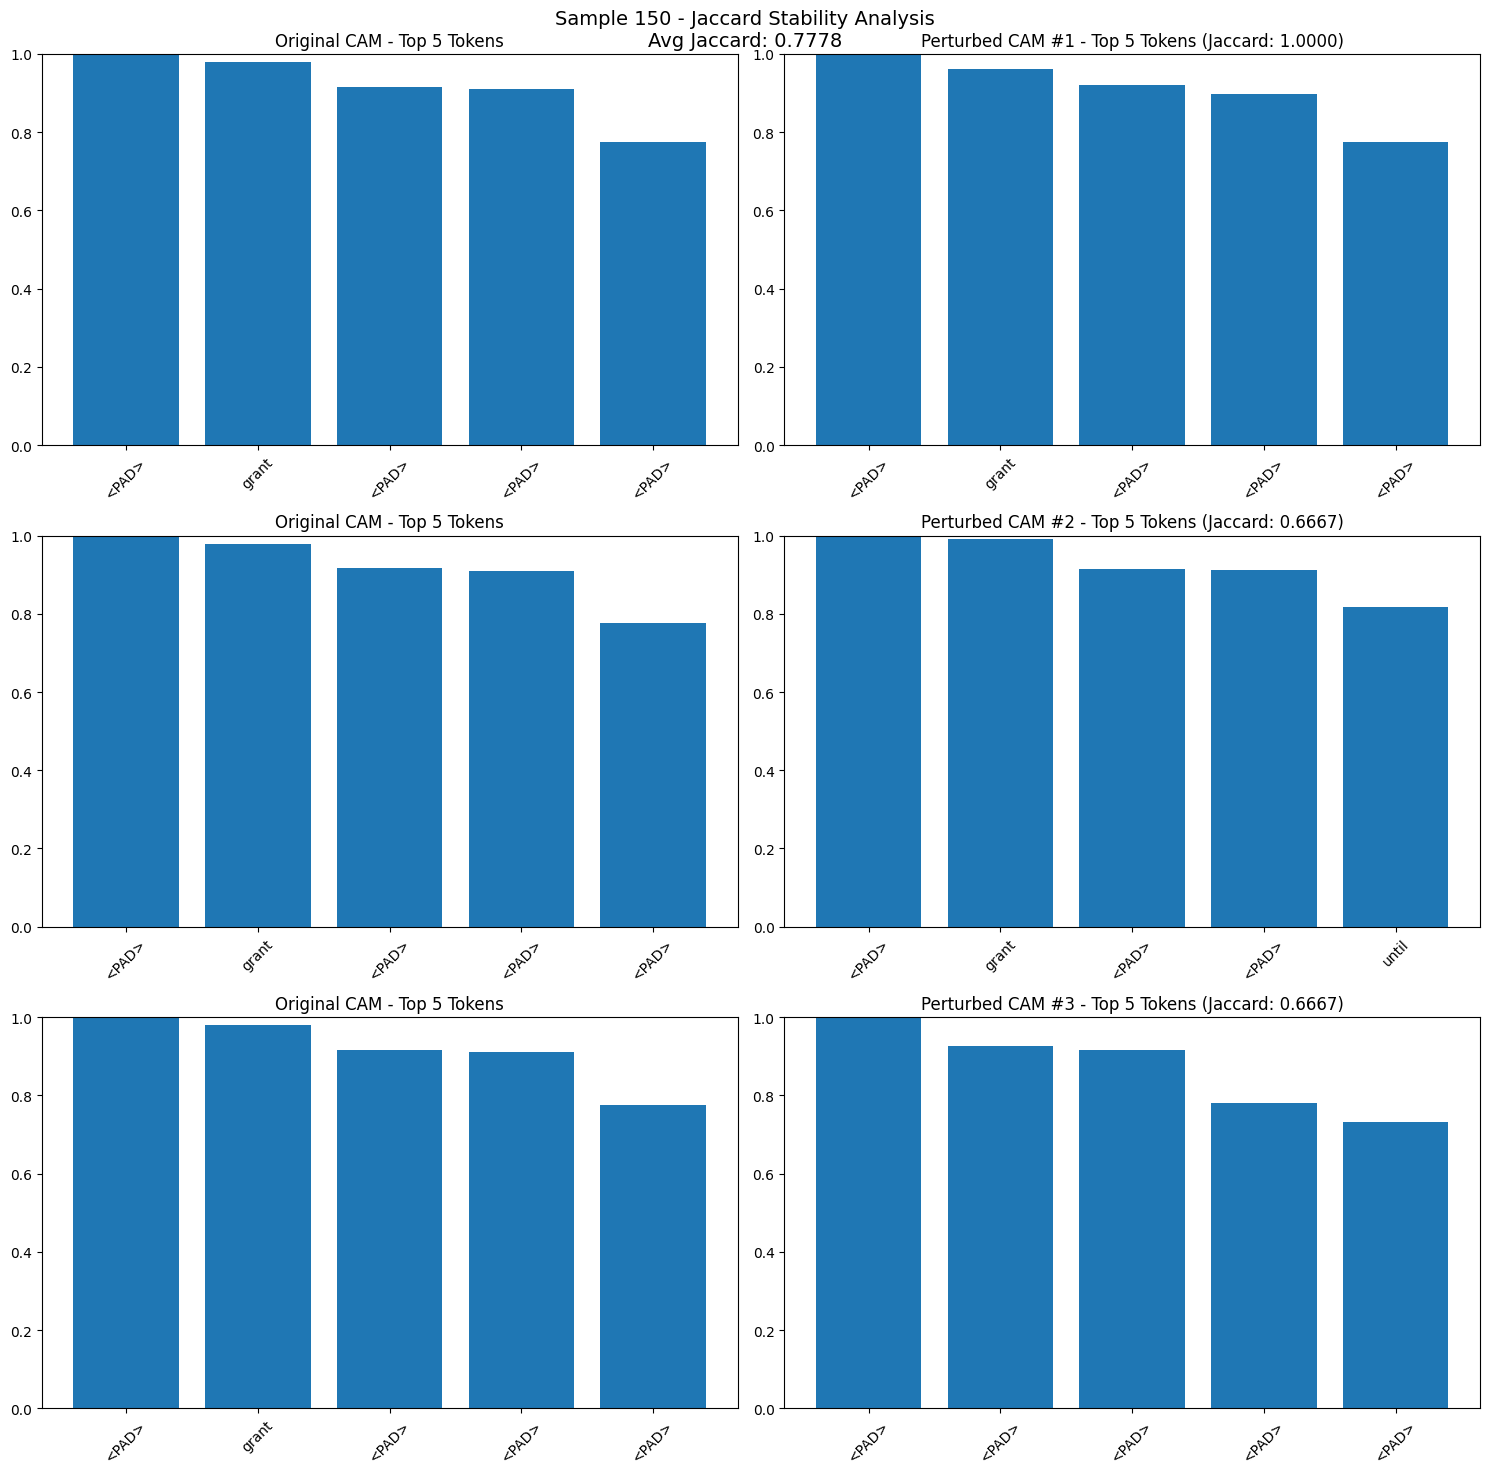

Average Jaccard stability: 0.7778

--- Sample 357 ---
Label: Ham
Top 5 tokens in original: following, visit, you, web, recommend


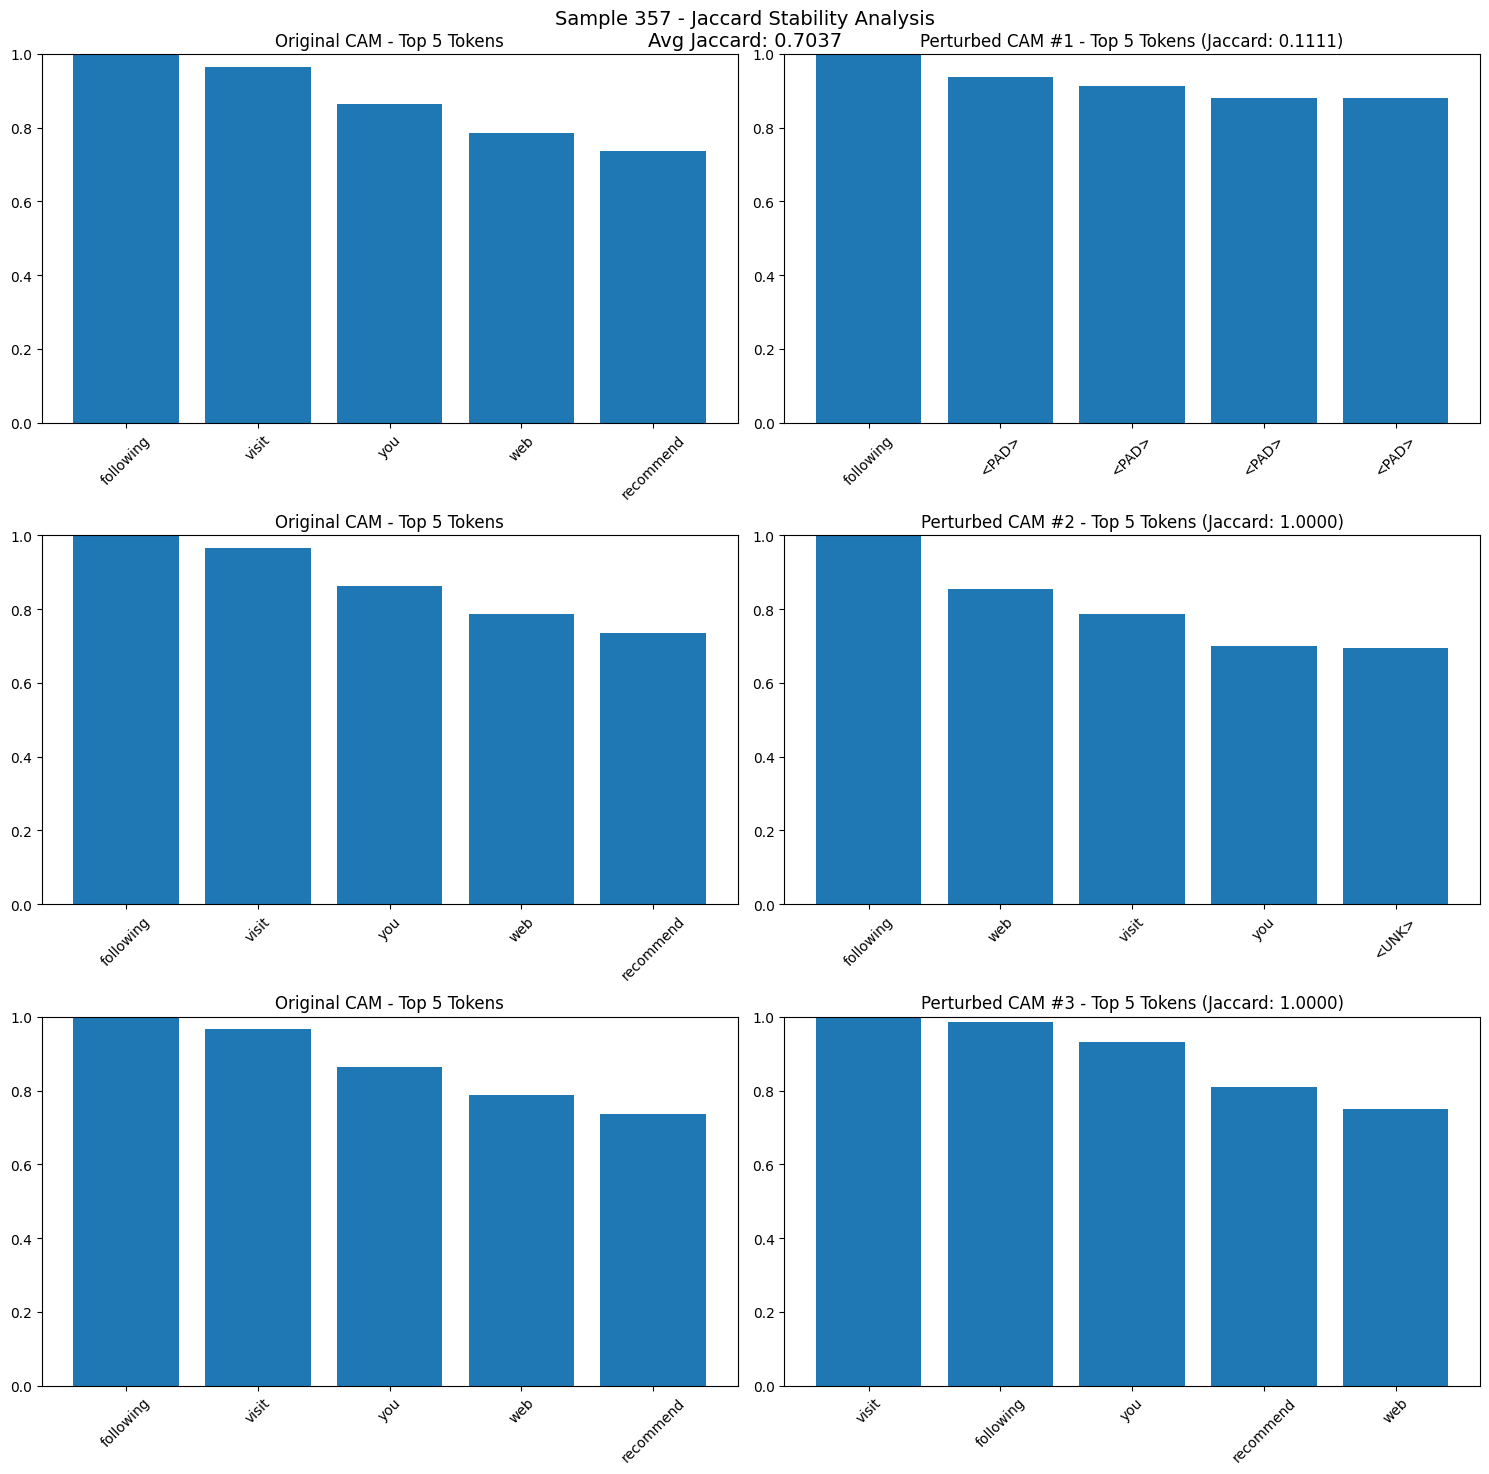

Average Jaccard stability: 0.7037

--- Sample 402 ---
Label: Ham
Top 5 tokens in original: you, probably, packages, should, <UNK>


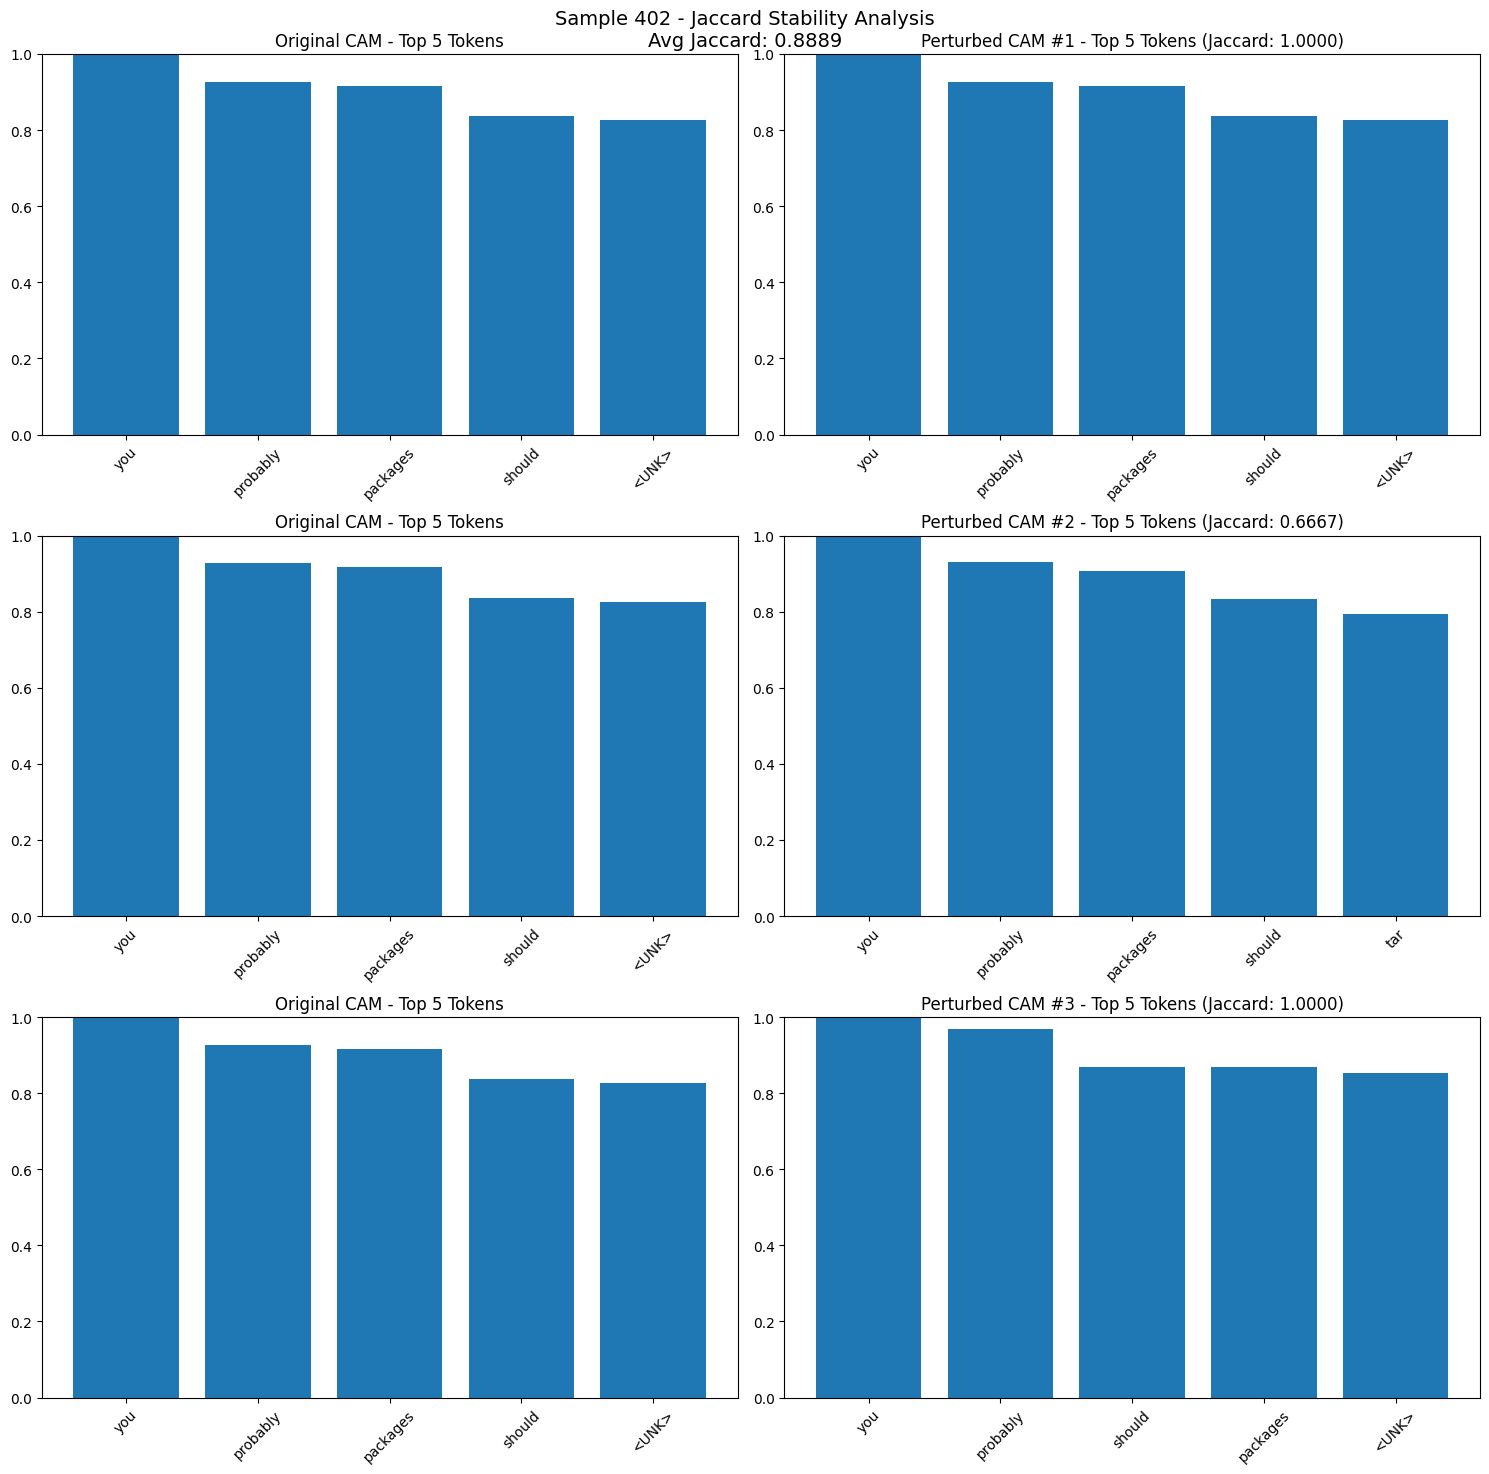

Average Jaccard stability: 0.8889

--- Sample 416 ---
Label: Spam
Top 5 tokens in original: below, receive, form, free, fill


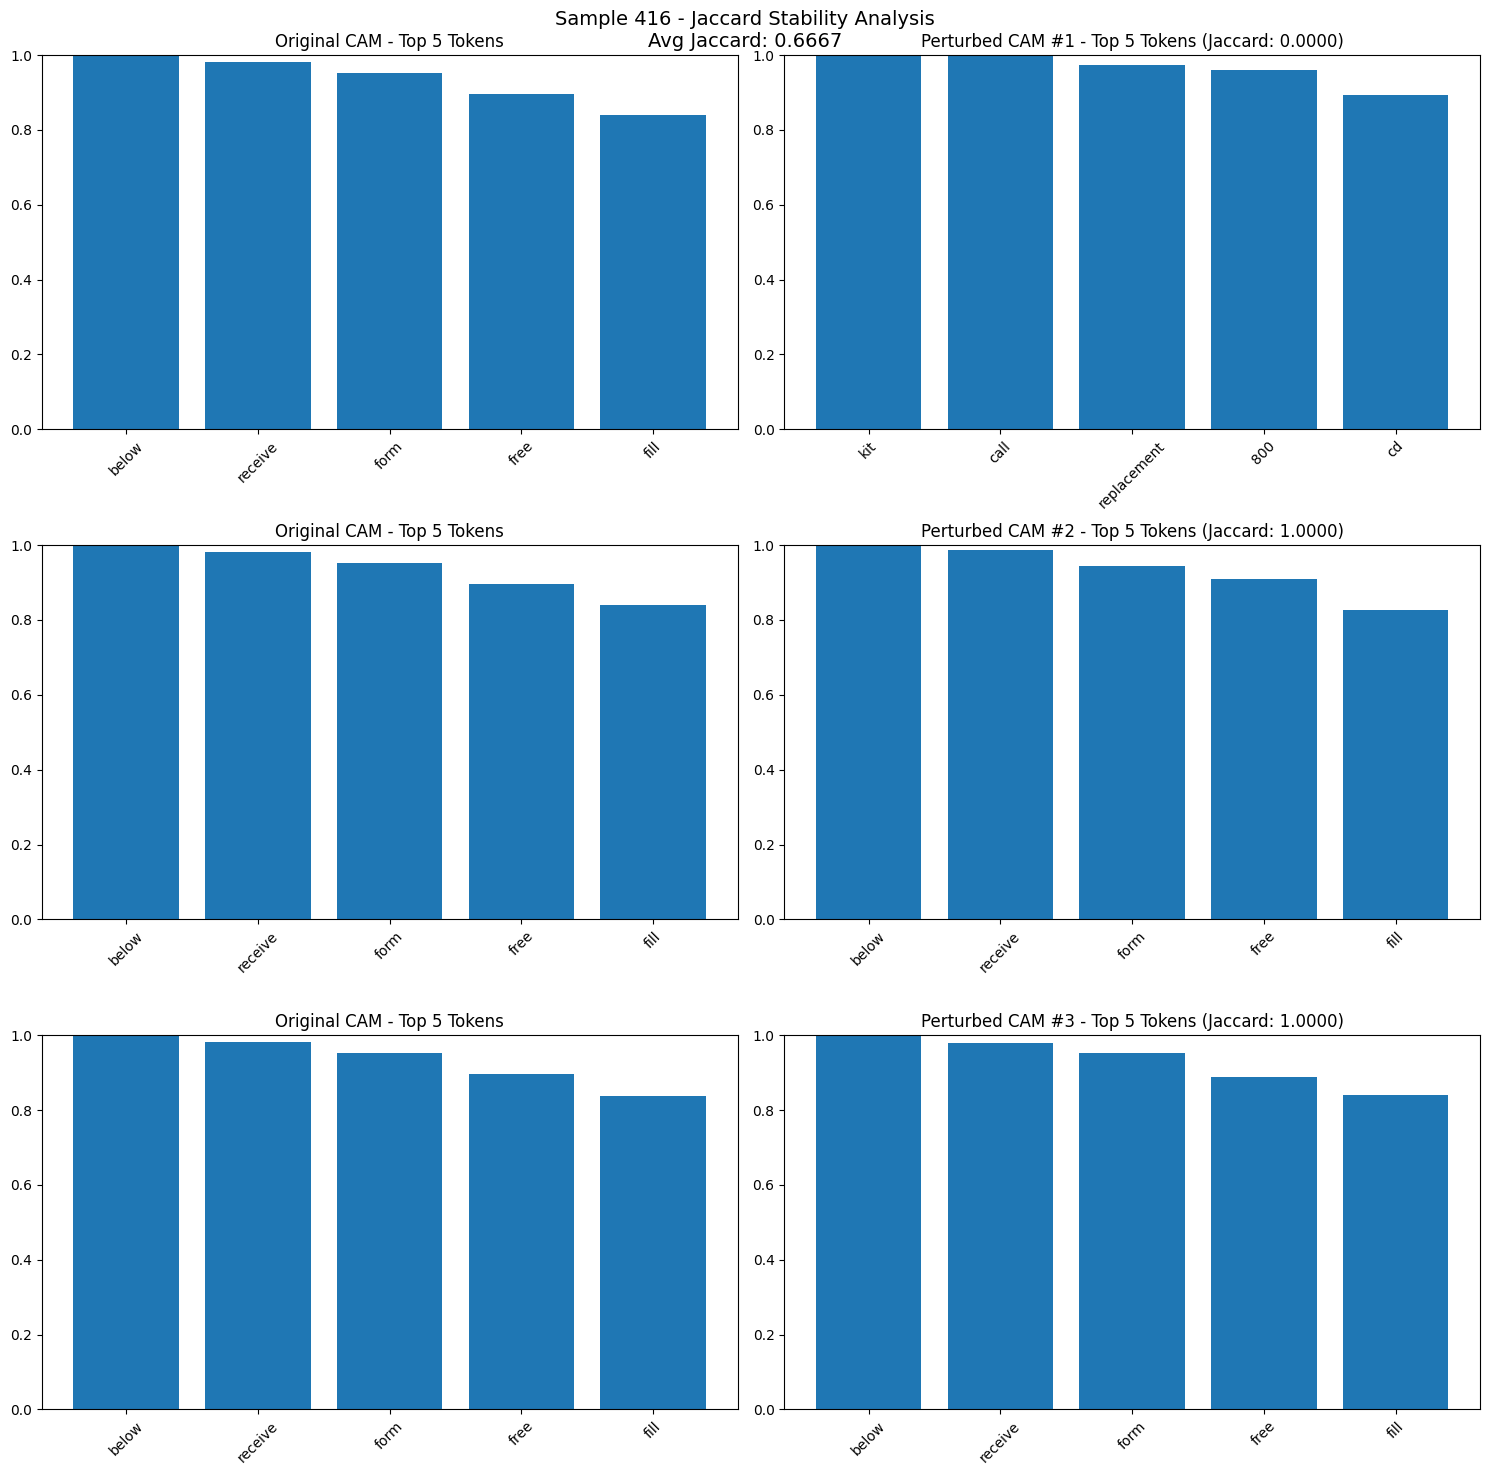

Average Jaccard stability: 0.6667


In [9]:
# Verify Jaccard stability for the same samples
for i in samples:
    sample_text = test_df['text'].iloc[i]
    print(f"\n--- Sample {i} ---")
    print(f"Label: {'Spam' if test_df['label'].iloc[i] == 1 else 'Ham'}")
    
    avg_jaccard = verify_jaccard_stability(
        cnn_model, 
        X_test_tensor[i], 
        cam_maps[i], 
        i,
        sample_text,
        k=5,
        num_perturbations=3
    )
    print(f"Average Jaccard stability: {avg_jaccard:.4f}")

### C. Analysis of Explanation Consistency Score (ECS)

The ECS combines multiple metrics to provide an overall score for explanation quality.
Let's examine its components and calculation:

In [10]:
def verify_ecs_calculation(model, x_batch, y_batch, cam_maps, num_samples=5):
    """Verify the calculation of ECS components"""
    model.eval()
    device = next(model.parameters()).device
    
    # Randomly sample indices to analyze
    if num_samples > len(x_batch):
        num_samples = len(x_batch)
    
    indices = np.random.choice(len(x_batch), num_samples, replace=False)
    
    # Collect component metrics
    results = []
    
    for idx in indices:
        x_single = x_batch[idx].to(device)
        cam_single = cam_maps[idx].to(device)
        
        # Calculate AUC-Del and AUC-Ins manually to verify
        from metrics.cnn_metrics import compute_auc_del, compute_auc_ins
        
        # These functions might be private within compute_explanation_metrics
        # If they're not accessible, implement them here
        
        # Simplified implementation for verification
        def calc_auc_del(x_single, cam_single):
            """Calculate AUC-Del for verification"""
            _, indices = torch.sort(cam_single, descending=True)
            deletions = []
            
            # Base prediction with all tokens
            with torch.no_grad():
                base_pred = model(x_single.unsqueeze(0).long()).item()
            deletions.append(base_pred)
            
            # Create mask for token deletion (PAD token)
            pad_token = 0
            
            # Sample a few points for the deletion curve
            steps = 10
            step_size = max(1, len(indices) // steps)
            
            for i in range(1, steps+1):
                step_idx = min(i * step_size, len(indices))
                
                # Create copy with top tokens masked
                x_perturbed = x_single.clone()
                x_perturbed[indices[:step_idx]] = pad_token
                
                with torch.no_grad():
                    pred = model(x_perturbed.unsqueeze(0).long()).item()
                deletions.append(pred)
            
            # Calculate AUC
            auc_del = np.trapz(deletions) / len(indices)
            return auc_del
        
        def calc_auc_ins(x_single, cam_single):
            """Calculate AUC-Ins for verification"""
            _, indices = torch.sort(cam_single, descending=True)
            insertions = []
            
            # Start with all tokens masked (PAD)
            pad_token = 0
            x_masked = torch.ones_like(x_single).long() * pad_token
            
            # Base prediction with all tokens masked
            with torch.no_grad():
                base_pred = model(x_masked.unsqueeze(0)).item()
            insertions.append(base_pred)
            
            # Sample a few points for the insertion curve
            steps = 10
            step_size = max(1, len(indices) // steps)
            
            for i in range(1, steps+1):
                step_idx = min(i * step_size, len(indices))
                
                # Reveal the top-i tokens
                x_perturbed = x_masked.clone()
                x_perturbed[indices[:step_idx]] = x_single[indices[:step_idx]]
                
                with torch.no_grad():
                    pred = model(x_perturbed.unsqueeze(0)).item()
                insertions.append(pred)
            
            # Calculate AUC
            auc_ins = np.trapz(insertions) / len(indices)
            return auc_ins
        
        # Calculate components for ECS
        auc_del_value = calc_auc_del(x_single, cam_single)
        auc_ins_value = calc_auc_ins(x_single, cam_single)
        
        # Calculate simplicity (sparsity of the CAM)
        simplicity = 1 - (torch.count_nonzero(cam_single) / cam_single.numel()).item()
        
        # Calculate faithfulness using the formula from the code
        faithfulness = (auc_ins_value - auc_del_value + 1) / 2
        
        # For stability, we would need to run perturbations
        # Using a placeholder value for this verification
        stability = 0.6  # Placeholder
        
        # Calculate ECS using the original formula
        ecs = 0.5 * faithfulness + 0.4 * stability + 0.1 * simplicity
        
        # Store results
        results.append({
            'sample_idx': idx.item() if isinstance(idx, torch.Tensor) else idx,
            'label': y_batch[idx].item(),
            'pred': model(x_single.unsqueeze(0).long()).item(),
            'auc_del': auc_del_value,
            'auc_ins': auc_ins_value,
            'faithfulness': faithfulness,
            'simplicity': simplicity,
            'stability': stability,
            'ecs': ecs
        })
    
    # Create DataFrame for display
    results_df = pd.DataFrame(results)
    
    # Plot component contributions
    plt.figure(figsize=(14, 7))
    
    # Component values
    plt.subplot(1, 2, 1)
    for i, row in results_df.iterrows():
        plt.bar(i, row['faithfulness'], bottom=0, width=0.5, color='skyblue', label='Faithfulness' if i==0 else '')
        plt.bar(i, row['stability'], bottom=row['faithfulness'], width=0.5, color='lightgreen', label='Stability' if i==0 else '')
        plt.bar(i, row['simplicity'], bottom=row['faithfulness']+row['stability'], width=0.5, color='salmon', label='Simplicity' if i==0 else '')
    
    plt.axhline(y=1, color='black', linestyle='-')
    plt.xlabel('Sample Index')
    plt.ylabel('Component Value')
    plt.title('ECS Components')
    plt.legend()
    
    # Weighted contributions
    plt.subplot(1, 2, 2)
    for i, row in results_df.iterrows():
        plt.bar(i, 0.5 * row['faithfulness'], bottom=0, width=0.5, color='skyblue', label='0.5 * Faithfulness' if i==0 else '')
        plt.bar(i, 0.4 * row['stability'], bottom=0.5 * row['faithfulness'], width=0.5, color='lightgreen', label='0.4 * Stability' if i==0 else '')
        plt.bar(i, 0.1 * row['simplicity'], bottom=0.5 * row['faithfulness'] + 0.4 * row['stability'], width=0.5, color='salmon', label='0.1 * Simplicity' if i==0 else '')
    
    plt.axhline(y=1, color='black', linestyle='-')
    plt.xlabel('Sample Index')
    plt.ylabel('Weighted Contribution')
    plt.title('ECS Weighted Components')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_df

In [11]:
# Verify ECS calculation
ecs_results = verify_ecs_calculation(
    cnn_model,
    X_test_tensor,
    y_test_tensor,
    cam_maps,
    num_samples=5
)

ecs_results

ImportError: cannot import name 'compute_auc_del' from 'metrics.cnn_metrics' (/app/metrics/cnn_metrics.py)

### D. Recommendations for Improving Explanation Metrics

Based on the analysis above, here are some recommendations for improving the calculation of explanation quality metrics:

In [12]:
import pandas as pd

recommendations = [
    {
        'Metric': 'AUC-Del',
        'Issue': 'The calculation may be overly sensitive to individual token removals',
        'Recommendation': 'Use percentage-based token removal instead of one-by-one token removal to create a smoother curve'
    },
    {
        'Metric': 'AUC-Ins', 
        'Issue': 'The insertion curve may be affected by padding tokens',
        'Recommendation': 'Start with a baseline input (UNK tokens) rather than PAD tokens to better simulate real-world scenarios'
    },
    {
        'Metric': 'Jaccard Stability',
        'Issue': 'The perturbation method (replacing with UNK) may not reflect realistic text variations',
        'Recommendation': 'Use synonym replacement or more natural word substitutions for perturbations'
    },
    {
        'Metric': 'ECS',
        'Issue': 'The weights (0.5, 0.4, 0.1) appear arbitrary and may not be optimal',
        'Recommendation': 'Tune these weights using a validation set to maximize correlation with human judgments'
    },
    {
        'Metric': 'All metrics',
        'Issue': 'Small batch sizes may lead to high variance in metric values',
        'Recommendation': 'Increase the number of samples evaluated and report confidence intervals'
    }
]

pd.DataFrame(recommendations)

,Metric,Issue,Recommendation
0,AUC-Del,The calculation may be overly sensitive to ind...,Use percentage-based token removal instead of ...
1,AUC-Ins,The insertion curve may be affected by padding...,Start with a baseline input (UNK tokens) rathe...
2,Jaccard Stability,The perturbation method (replacing with UNK) m...,Use synonym replacement or more natural word s...
3,ECS,"The weights (0.5, 0.4, 0.1) appear arbitrary a...",Tune these weights using a validation set to m...
4,All metrics,Small batch sizes may lead to high variance in...,Increase the number of samples evaluated and r...
